# JSS Performance Evaluation

We collect data from N runs processing 100 deployment changes moving the accounting node between Germany and the USA.

Initially, we read the (test) data frame containing values for
 * total time between incoming event (this should be also measuring time) and reconfiguration of probes
 * model update includes code to model level mapping and actual PCM model update
 * privacy update is the complete time necessary to recomupte the privacy properties
 * configuration time is the time used to take the privacy result, compute probe configuration and probe reconfiguration.

In [75]:
data <- read.csv(sprintf("data/results/single-migration/jss-result-%d.csv", 0))
for (loop in 1:999) {
    input = read.csv(sprintf("data/results/single-migration/jss-result-%d.csv", loop))
    data <- rbind(data, input)
}

length(data[,1])

[1] 28000

## Load plot libraries and define common R functions

In [76]:
library(ggplot2)
library(magrittr)
library(ggpubr)
library(repr)

plotFunc <- function(input, column, label, upperLimit, shape) {
    col <- input[,column]
    return (ggplot(input, aes (y=col, x="")) + geom_boxplot(outlier.shape = shape) + ylab("Time [ns]") + xlab(label) + ylim(0,upperLimit))
}

plotAll <- function(data, upperlimit, shape){
    plots <- list()

    i <- 1
    for (label in colnames(data)) {
        if ( i > 1 ) {
            label <- gsub("[.]", " ",label)
            plots[[i-1]] <- plotFunc(data,i,label,upperLimit, shape)
        }
        i <- i + 1
    }

    ggarrange(plotlist=plots, ncol = length(plots), nrow = 1)
}

options(repr.plot.height=3)

## Measurements

Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”

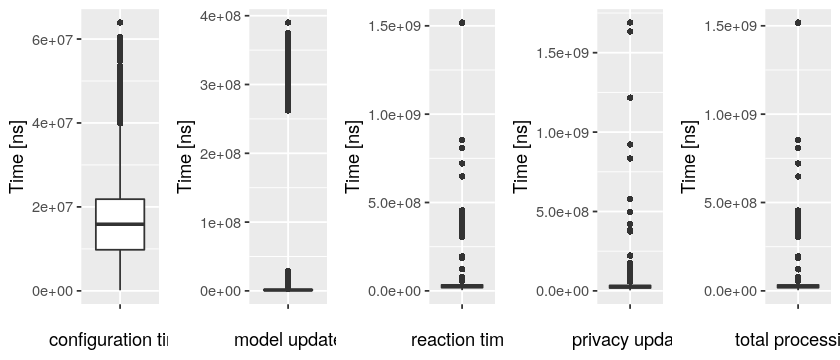

In [77]:
upperLimit <- max(data[,"total.processing"],data[,"reaction.time"])

plotAll(data,upperLimit, 16)

Measurements over Time

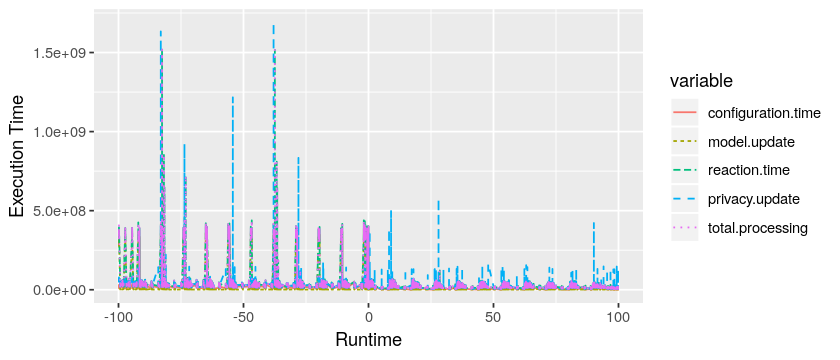

In [89]:
library(reshape2)

plotData <- data
plotData[,"date"] <- plotData[,"date"]/1000/1000/1000

allColumns <- colnames(data)
measureColumns <- allColumns[2:length(allColumns)]

ggData <- melt(plotData, id.vars = "date", measure.vars = measureColumns)

ggplot(ggData, aes(x=date, y=value, linetype = variable, color = variable)) + geom_line() + xlab("Runtime") + ylab("Execution Time")

## Measurements without depicting outliers

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1000 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1093 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 713 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1094 rows containing non-finite values (stat_boxplot).”

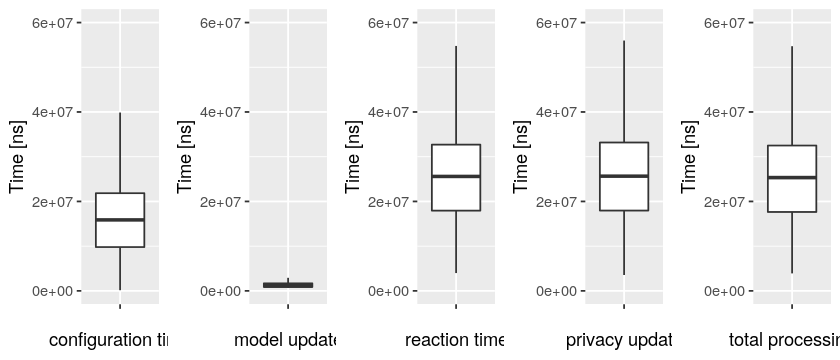

In [79]:
upperLimit <- 60000000

plotAll(data, upperLimit, NA)

In [88]:
label.vals <- c()
mean.vals <- c()
median.vals <- c()
var.vals <- c()

unit.conversion <- 1000 * 1000

cleaned <- subset(data, !is.na(total.processing))

i <- 1
for (label in colnames(data)) {
    label.vals[[i]] <- gsub("[.]", " ",label)
    input <- cleaned[,i] / unit.conversion
    
    median.vals[[i]] <- median(input, na.rm=TRUE)
    mean.vals[[i]] <- mean(input, na.rm=TRUE)
    var.vals[[i]] <- var(input, na.rm=TRUE)
    i <- i + 1
}

result <- data.frame("measurement" = label.vals, "mean" = mean.vals, "median" = median.vals, "variance" = var.vals)

result

measurement,mean,median,variance
date,5682.93200,2747.469947,2.292325e+09
configuration time,16.51840,15.871822,7.703086e+01
model update,12.48109,1.184062,3.142712e+03
reaction time,38.20255,26.081771,4.146835e+03
privacy update,27.80155,25.990781,5.176094e+02
total processing,37.95009,25.854948,4.138252e+03


All values are in milli seconds.
* _Total processing_ time is the sum of _privacy update_ time and _model update_ time
* _Reaction time_ includes _configuration time_ and _total processing_ time. Still it is lower than _configuration time_ plus _total processing_ time, as the filters for _privacy update_, _model update_ and _configuration_ run in separate threads.